# Crop Disease Classification

In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
data_dir = "../data"
CHANNELS = 3
EPOCHS = 50

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 20638 files belonging to 15 classes.


### Checking the Available Classes

In [6]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

15 ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


### Displaying Some Sample Images

2024-10-28 19:45:49.536147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 361 of 10000
2024-10-28 19:46:00.516881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 566 of 10000
2024-10-28 19:46:04.693448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-10-28 19:46:06.637200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


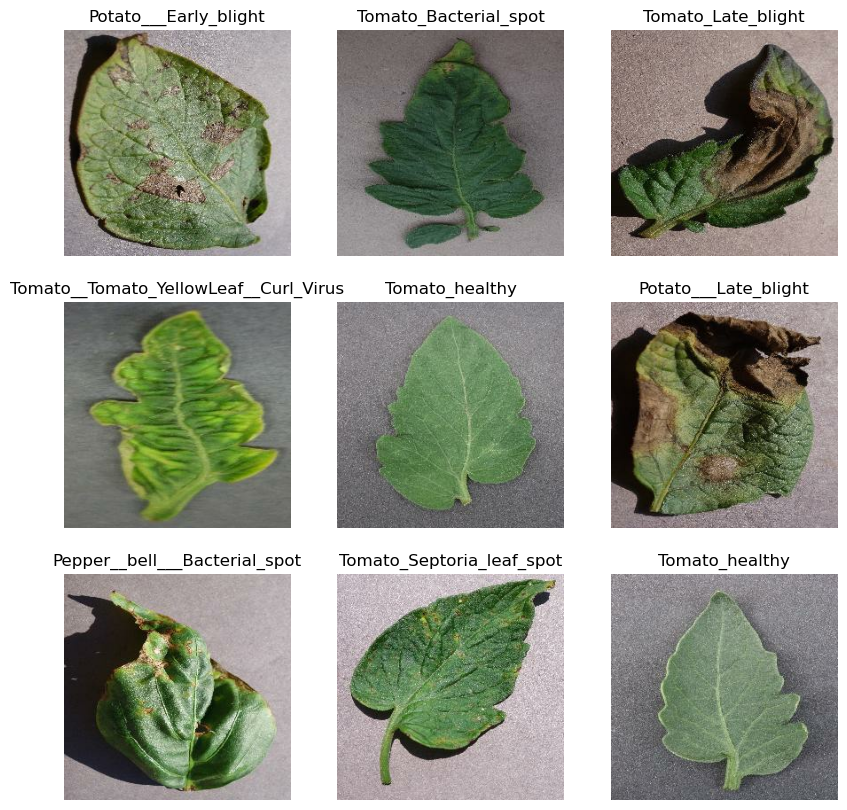

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Checking Batch Size

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
from tensorflow.keras import backend as K

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture

In [16]:
model = models.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(dataset.class_names), activation='softmax'),
])

### Compiling the Model

In [17]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

### Training the Network

In [18]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)

Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.4739 - loss: 2.1266

2024-10-28 19:56:51.820204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 493 of 10000
2024-10-28 19:56:57.617375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-10-28 19:56:58.324154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


516/516 ━━━━━━━━━━━━━━━━━━━━ 477s 906ms/step - accuracy: 0.4743 - loss: 2.1249 - val_accuracy: 0.8291 - val_loss: 0.5556
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 473s 916ms/step - accuracy: 0.8579 - loss: 0.4388 - val_accuracy: 0.9048 - val_loss: 0.3044
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 473s 916ms/step - accuracy: 0.9392 - loss: 0.1847 - val_accuracy: 0.9351 - val_loss: 0.2365
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 487s 945ms/step - accuracy: 0.9753 - loss: 0.0879 - val_accuracy: 0.9443 - val_loss: 0.2192
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.9838 - loss: 0.0528 - val_accuracy: 0.9414 - val_loss: 0.2500
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 536s 1s/step - accuracy: 0.9828 - loss: 0.0497 - val_accuracy: 0.9248 - val_loss: 0.3472
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.9860 - loss: 0.0422 - val_accuracy: 0.9487 - val_loss: 0.2771
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 650s 1s/step - accuracy: 0.9839 - loss: 0.0454 - val_acc

### Testing the Model

In [19]:
print("Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

Calculating model accuracy


2024-10-29 02:12:03.410044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 397 of 10000
2024-10-29 02:12:09.592863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-10-29 02:12:10.645315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 ━━━━━━━━━━━━━━━━━━━━ 43s 392ms/step - accuracy: 0.9707 - loss: 0.3019
Test Accuracy: 96.3%


In [22]:
def save_model_with_plant_grouping(model, dataset, base_path="../models"):
    os.makedirs(base_path, exist_ok=True)
    
    plant_groups = {
        'Pepper': [],
        'Tomato': [],
        'Potato': []
    }
    
    for class_name in dataset.class_names:
        if class_name.startswith('Pepper'):
            plant_groups['Pepper'].append(class_name)
        elif class_name.startswith('Tomato'):
            plant_groups['Tomato'].append(class_name)
        elif class_name.startswith('Potato'):
            plant_groups['Potato'].append(class_name)
    
    for plant_type, classes in plant_groups.items():
        if not classes:
            continue
            
        plant_dir = os.path.join(base_path, plant_type)
        os.makedirs(plant_dir, exist_ok=True)
        
        existing_versions = [
            int(folder) for folder in os.listdir(plant_dir) 
            if folder.isdigit()
        ]
        version = max(existing_versions, default=0) + 1
        
        model_path = os.path.join(plant_dir, str(version))
        os.makedirs(model_path, exist_ok=True)
        
        model_file_path = os.path.join(model_path, "model.keras")
        try:
            model.save(model_file_path)
            print(f"\nModel for {plant_type} saved successfully in {model_path}")
            print(f"Includes classes: {', '.join(classes)}")
        except Exception as e:
            print(f"Error saving model for {plant_type}: {str(e)}")

save_model_with_plant_grouping(model, dataset)


Model for Pepper saved successfully in ../models/Pepper/1
Includes classes: Pepper__bell___Bacterial_spot, Pepper__bell___healthy

Model for Tomato saved successfully in ../models/Tomato/1
Includes classes: Tomato_Bacterial_spot, Tomato_Early_blight, Tomato_Late_blight, Tomato_Leaf_Mold, Tomato_Septoria_leaf_spot, Tomato_Spider_mites_Two_spotted_spider_mite, Tomato__Target_Spot, Tomato__Tomato_YellowLeaf__Curl_Virus, Tomato__Tomato_mosaic_virus, Tomato_healthy

Model for Potato saved successfully in ../models/Potato/1
Includes classes: Potato___Early_blight, Potato___Late_blight, Potato___healthy
